# Thermovision segmentation (altitude & rotation)

## HIT-UAV Dataset

*HIT-UAV provides essential flight data for each image, including flight altitude, camera perspective, date, and daylight intensity. <br>
For each image, the authors have manually annotated object instances with bounding boxes of two types (oriented and standard) <br>to tackle the challenge of significant overlap of object instances in aerial images.*

In [1]:
from pathlib import Path

import cv2
import numpy as np

from src.data import save_alt_rot_images_annotations
from src.utils.process_image import add_altitude_rotation_channel
from src.utils.read_file import XMLReader, read_file_to_list
from src.visualizations import plot_rotated_images

ANNOTATIONS_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/Annotations"
DATA_SPLIT_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/ImageSets/Main"
IMAGES_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/JPEGImages"

#### Load annotations

In [2]:
xml_reader = XMLReader(ANNOTATIONS_PATH)
annotations = xml_reader.getAnnotation()

In [3]:
# examplary annotation
annotations['0_100_30_0_03280']

{'picname': 'C:\\Users\\suoji\\Desktop\\data_pro\\images_data_new\\day\\100m\\-30\\20210116\\0_100_30_0_03280.jpg',
 'size': {'width': 640, 'height': 512, 'depth': 1},
 'nobbox': [],
 'robbox': [{'category': 'Car',
   'cx': 215.984,
   'cy': 120.9863,
   'w': 32.276,
   'h': 15.9103,
   'angle': 2.589049,
   'difficult': False},
  {'category': 'Car',
   'cx': 373.7907,
   'cy': 97.5358,
   'w': 27.4285,
   'h': 19.3339,
   'angle': 0.559865,
   'difficult': False},
  {'category': 'Car',
   'cx': 134.6054,
   'cy': 141.7191,
   'w': 25.4252,
   'h': 18.4471,
   'angle': 2.279669,
   'difficult': False},
  {'category': 'Car',
   'cx': 32.4545,
   'cy': 200.0871,
   'w': 27.7836,
   'h': 13.3051,
   'angle': 0.796474,
   'difficult': False},
  {'category': 'Car',
   'cx': 43.7676,
   'cy': 192.7359,
   'w': 31.907,
   'h': 17.0008,
   'angle': 0.650521,
   'difficult': False},
  {'category': 'Car',
   'cx': 58.5022,
   'cy': 187.6378,
   'w': 14.5995,
   'h': 32.0022,
   'angle': 2.335935

In [4]:
image_names = dict()
for key in ["train", "val", "test"]:
    image_names[key] = read_file_to_list(f"{DATA_SPLIT_PATH}/{key}.txt")

#### Visualize n random images from the training set

In [5]:
n = 15
random_images = np.random.choice(np.arange(len(image_names['train'])), n, replace=False)
random_images = [image_names['train'][i] for i in random_images]
# random_images

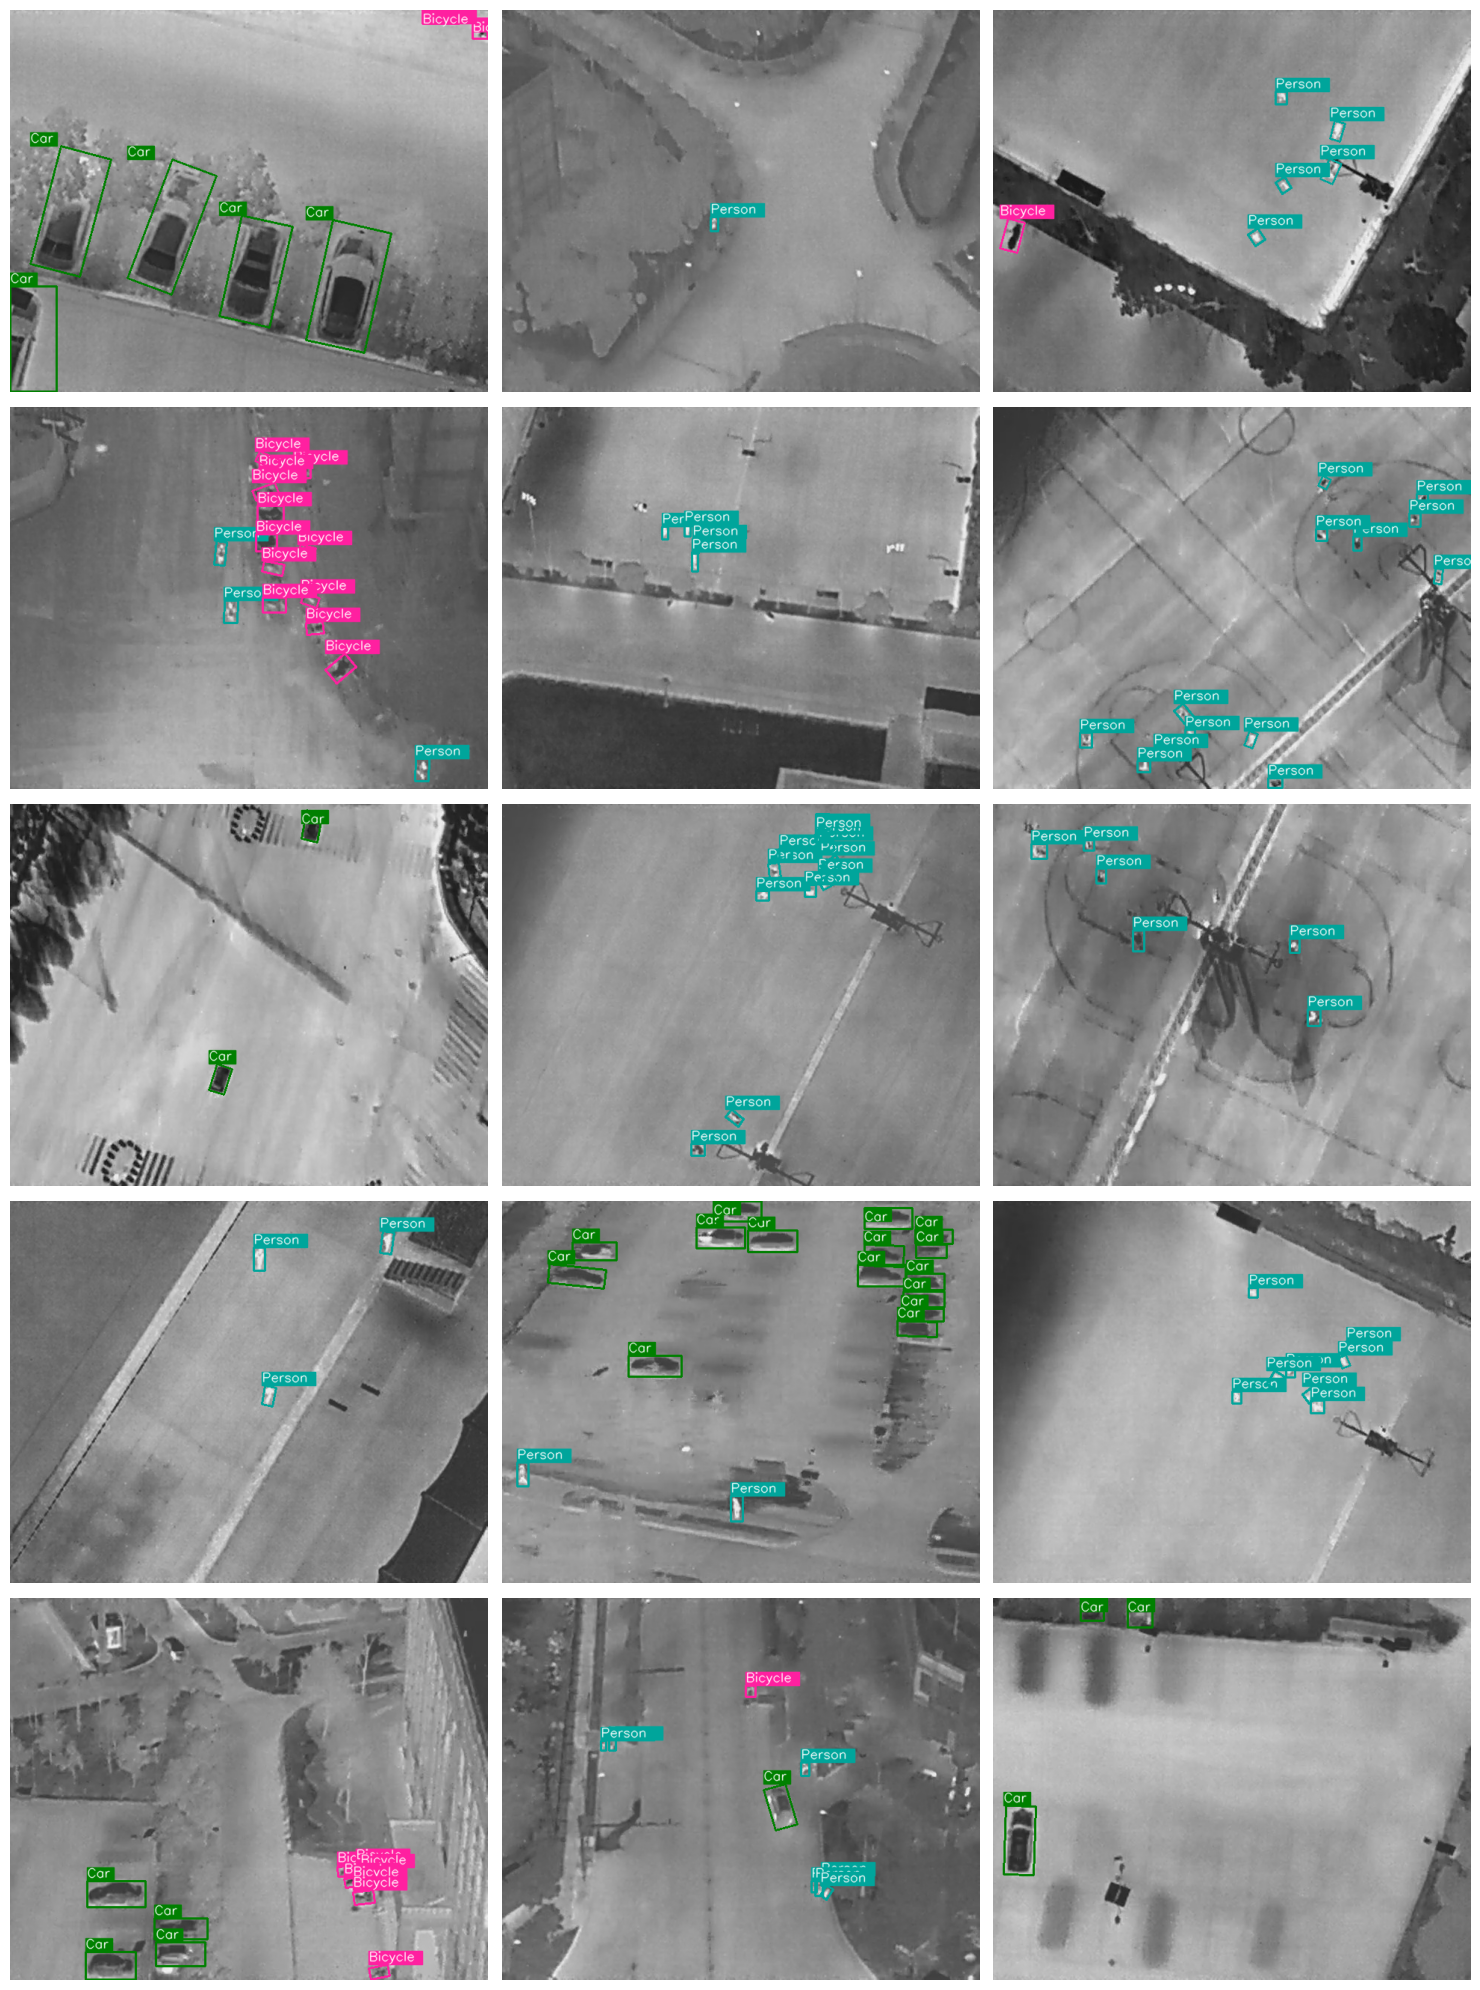

In [6]:
rows = 5
cols = 3
plot_rotated_images(IMAGES_PATH, random_images, annotations, rows, cols)

### Add the altitude information as an additional input channel

Following the idea from the paper: [Elevating point-based object detection in UAVs: A deep learning method with altitude fusion](https://ww2.mini.pw.edu.pl/pprai2024/papers/105.pdf) <br>(presented at the PP RAI 2024 conference), we added the information about the altitude as a separate channel (i.e. using *Method A*):

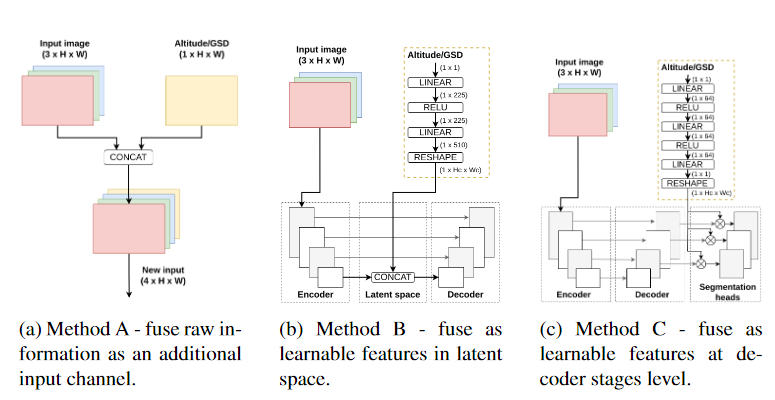

In [7]:
image_name = image_names['train'][0]

image = cv2.imread(f"{IMAGES_PATH}/{image_name}.jpg")

In [8]:
print(image_name)
image_alt_rot = add_altitude_rotation_channel(image, image_name)
print(image_alt_rot.shape)
image_alt_rot

1_130_90_0_04077
(512, 640, 3)


array([[[120, 130,  90],
        [118, 130,  90],
        [118, 130,  90],
        ...,
        [145, 130,  90],
        [145, 130,  90],
        [146, 130,  90]],

       [[119, 130,  90],
        [117, 130,  90],
        [117, 130,  90],
        ...,
        [146, 130,  90],
        [148, 130,  90],
        [148, 130,  90]],

       [[118, 130,  90],
        [119, 130,  90],
        [120, 130,  90],
        ...,
        [147, 130,  90],
        [149, 130,  90],
        [149, 130,  90]],

       ...,

       [[118, 130,  90],
        [119, 130,  90],
        [123, 130,  90],
        ...,
        [137, 130,  90],
        [140, 130,  90],
        [141, 130,  90]],

       [[123, 130,  90],
        [122, 130,  90],
        [122, 130,  90],
        ...,
        [139, 130,  90],
        [143, 130,  90],
        [145, 130,  90]],

       [[126, 130,  90],
        [122, 130,  90],
        [120, 130,  90],
        ...,
        [142, 130,  90],
        [147, 130,  90],
        [150, 130,  90]]

In [10]:
img_dir = Path("data/data_rotated/images")
class_dict = {"Person": 0, "Car": 1, "Bicycle": 2, "OtherVehicle": 3, "DontCare": 4}
ann_dir = Path("data/data_rotated/labels")
save_alt_rot_images_annotations(img_dir, ann_dir, image_names, IMAGES_PATH, annotations, class_dict)

## Train oriented bounding box yolo (OBB)

In [11]:
from ultralytics import YOLO

model = YOLO("yolov8n-obb.yaml")
results = model.train(data="data/data_rotated/dataset.yaml", imgsz=512, epochs=5, batch=4)

New https://pypi.org/project/ultralytics/8.2.8 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA T500, 1871MiB)
engine/trainer: task=obb, mode=train, model=yolov8n-obb.yaml, data=data/data_rotated/dataset.yaml, epochs=5, time=None, patience=100, batch=4, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

train: Scanning /home/zuzgaw/uni/I/machine perception/thermal-segmentation/data/data_rotated/labels/train... 2029 images, 21 backgrounds, 0 corrupt: 100%|██████████| 2029/2029 [00:00<00:00, 3111.15it/s]


train: New cache created: /home/zuzgaw/uni/I/machine perception/thermal-segmentation/data/data_rotated/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/zuzgaw/uni/I/machine perception/thermal-segmentation/data/data_rotated/labels/val... 290 images, 3 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<00:00, 2544.02it/s]

val: New cache created: /home/zuzgaw/uni/I/machine perception/thermal-segmentation/data/data_rotated/labels/val.cache


Plotting labels to runs/obb/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/obb/train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5     0.686G      5.181       4.85      4.121         39        512:  32%|███▏      | 165/508 [00:40<01:24,  4.05it/s]